<a href="https://colab.research.google.com/github/gRedDeer/kaggle_notebooks/blob/main/Mnist_digit_cnn_fn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
#!kaggle datasets list
#!mkdir -p /content/drive/MyDrive/Kaggle/digit-recognizer
%cd /content/drive/MyDrive/Kaggle/
#kaggle competitions download -c digit-recognizer
#cp digit-recognize.zip /digit-recognizer/

#unzip -q digit-recognizer/digit-recognizer.zip
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle


['Loan Approval Prediction',
 '.ipynb_checkpoints',
 'kaggle.json',
 'config.txt',
 'digit-recognizer']

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pwd

'/content/drive/MyDrive/Kaggle'

In [4]:
# Read the data
train_data = pd.read_csv('digit-recognizer/train.csv')
test_data = pd.read_csv("digit-recognizer/test.csv")

In [5]:
train_data.shape, test_data.shape

((42000, 785), (28000, 784))

In [6]:
# Set up the data
y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values/255
X_test = test_data.values/255

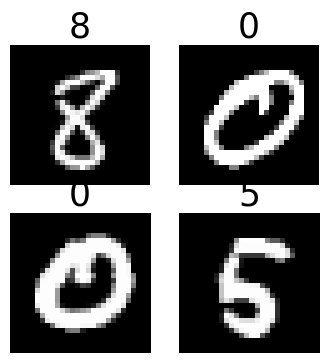

In [7]:
fig, axes = plt.subplots(2,2, figsize=(4,4))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=4)
for i in range(4):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [8]:
# relu activation function
# THE fastest vectorized implementation for ReLU
def relu(x):
    x[x<0]=0
    return x

In [9]:
def h(X,W,b):
    '''
    Hypothesis function: simple FNN with 1 hidden layer
    Layer 1: input
    Layer 2: hidden layer, with a size implied by the arguments W[0], b
    Layer 3: output layer, with a size implied by the arguments W[1]
    '''
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]

    # add one more layer if applicable

    # layer 2 activation
    a2 = relu(z1)
    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    # the output is a probability for each sample
    return sigma

In [10]:
def softmax(X_in,weights):
    '''
    Un-used cell for demo
    activation function for the last FC layer: softmax function
    Output: K probabilities represent an estimate of P(y=k|X_in;weights) for k=1,...,K
    the weights has shape (n, K)
    n: the number of features X_in has
    n = X_in.shape[1]
    K: the number of classes
    K = 10
    '''

    s = np.exp(np.matmul(X_in,weights))
    total = np.sum(s, axis=1).reshape(-1,1)
    return s / total

In [11]:
def loss(y_pred,y_true):
    '''
    Loss function: cross entropy with an L^2 regularization
    y_true: ground truth, of shape (N, )
    y_pred: prediction made by the model, of shape (N, K)
    N: number of samples in the batch
    K: global variable, number of classes
    '''
    global K
    K = 10
    N = len(y_true)
    # loss_sample stores the cross entropy for each sample in X
    # convert y_true from labels to one-hot-vector encoding
    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(K))
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)
    # loss_sample is a dimension (N,) array
    # for the final loss, we need take the average
    return -np.mean(loss_sample)

In [12]:
def backprop(W,b,X,y,alpha=1e-4):
    '''
    Step 1: explicit forward pass h(X;W,b)
    Step 2: backpropagation for dW and db
    '''
    K = 10
    N = X.shape[0]

    ### Step 1:
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    # layer 2 activation
    a2 = relu(z1)

    # one more layer

    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total

    ### Step 2:

    # layer 2->layer 3 weights' derivative
    # delta2 is \partial L/partial z2, of shape (N,K)
    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta2 = (sigma - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)

    # layer 1->layer 2 weights' derivative
    # delta1 is \partial a2/partial z1
    # layer 2 activation's (weak) derivative is 1*(z1>0)
    delta1 = np.matmul(delta2, W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)

    # Possible student project: extra layer of derivative

    # no derivative for layer 1

    # the alpha part is the derivative for the regularization
    # regularization = 0.5*alpha*(np.sum(W[1]**2) + np.sum(W[0]**2))


    dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1]]
    db = [np.mean(delta1, axis=0)]
    # dW[0] is W[0]'s derivative, and dW[1] is W[1]'s derivative; similar for db
    return dW, db

Hyper-parameters and network initialization

In [13]:
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop
num_iter = 1000 # number of iterations of gradient descent
n_H = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

In [14]:
# initialization
np.random.seed(1127825)
W = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, K)]
b = [np.random.randn(n_H)]


In [15]:
%%time
gW0 = gW1 = gb0 = 1

for i in range(num_iter):
    dW, db = backprop(W,b,X_train,y_train,alpha)

    gW0 = gamma*gW0 + (1-gamma)*np.sum(dW[0]**2)
    etaW0 = eta/np.sqrt(gW0 + eps)
    W[0] -= etaW0 * dW[0]

    gW1 = gamma*gW1 + (1-gamma)*np.sum(dW[1]**2)
    etaW1 = eta/np.sqrt(gW1 + eps)
    W[1] -= etaW1 * dW[1]

    gb0 = gamma*gb0 + (1-gamma)*np.sum(db[0]**2)
    etab0 = eta/np.sqrt(gb0 + eps)
    b[0] -= etab0 * db[0]

    if i % 500 == 0:
        # sanity check 1
        y_pred = h(X_train,W,b)
        print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(
              loss(y_pred,y_train)))
        print("Training accuracy after", i+1, "iterations is {:.4%}".format(
              np.mean(np.argmax(y_pred, axis=1)== y_train)))

        # sanity check 2
        print("gW0={:.4f} gW1={:.4f} gb0={:.4f}\netaW0={:.4f} etaW1={:.4f} etab0={:.4f}"
              .format(gW0, gW1, gb0, etaW0, etaW1, etab0))

        # sanity check 3
        print("|dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}"
             .format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")

        # reset RMSprop
        gW0 = gW1 = gb0 = 1

y_pred_final = h(X_train,W,b)
print("Final cross-entropy loss is {:.8}".format(loss(y_pred_final,y_train)))
print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_train)))

Cross-entropy loss after 1 iterations is 7.6743264
Training accuracy after 1 iterations is 24.9262%
gW0=1.0839 gW1=1.3825 gb0=0.9923
etaW0=0.4800 etaW1=0.4251 etab0=0.5017
|dW0|=3.06418 |dW1|=6.26530 |db0|=0.48001 



KeyboardInterrupt: 

In [16]:
# predictions
y_pred_test = np.argmax(h(X_test,W,b), axis=1)

In [17]:
# Generating submission using pandas for grading
submission = pd.DataFrame({'ImageId': range(1,len(X_test)+1) ,'Label': y_pred_test })
submission.to_csv("simplemnist_result.csv",index=False)